# Intro to Machine Learning: Supervised Learning
### Titanic ML models analysis
This is the project with the objective to predict if a Titatnic passenger survied. This is a Kaggle dataset used for the competition to see who can build a good predictor for the problem. If you want to check the problem in detail you can visit the Kaggle page [here](https://www.kaggle.com/competitions/titanic/overview).

#### Libraries to Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#sklean libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

#### Data Sourcing and EDA

First I'm going to read the CSV from the data set I'm focusing on to make them usable in this notebook. After we verify the data is all set up I'm going to do some EDA to see what we might need to modify in order to run it through the models and predict the **Survived** column.

In [2]:
# Upload Data
test_result = pd.read_csv('./data/gender_submission.csv')
test_features = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')
test = pd.merge(test_features,test_result, on='PassengerId')

Brief overview of the data we're going to be working with to get some statistics and clean up the sets I'll be using.

In [3]:
# EDA
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
missing_info = train.isna().sum()
missing_info_percent = missing_info/train.shape[0] * 100
print(missing_info, missing_info_percent)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


From this first overview we can see that the dataset has both numeric and categorical fields.
* Numeric: age, sibsp, parch, fare
* Categorical: pcalss, sex, embarked
* Other features: name, ticket, cabin, passengerid

The reason I'm point out ther are other features is because we might be able to drop these from the features because of the following reasons:
* Names: This is irrelevant data that brings no value to the objective of the model, this might add noise and every single value is different.
* Ticket: Similar to the name every ticket number might be able to help but the possibility is really low, we might need to deep dive on the ticket numbers to attain some context on what does the numbers and letters mean in the ticket feature.
* Cabin: Derived from our EDA we see that **77%** of the data is missing so I've decided to get rid of this feature
* PassengerID: this one was basically used to identify each passenger but for this case we do not need that information since we want random samples and we've been provided a train and test sets.

**We need to do all of these changes to both the train and test sets in order for the model to work and be comparable.**

In [6]:
#Impute missing Values of Age with median looking at the histogram
train['Age'].fillna(train['Age'].median(), inplace=True)

test['Age'].fillna(test['Age'].median(), inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

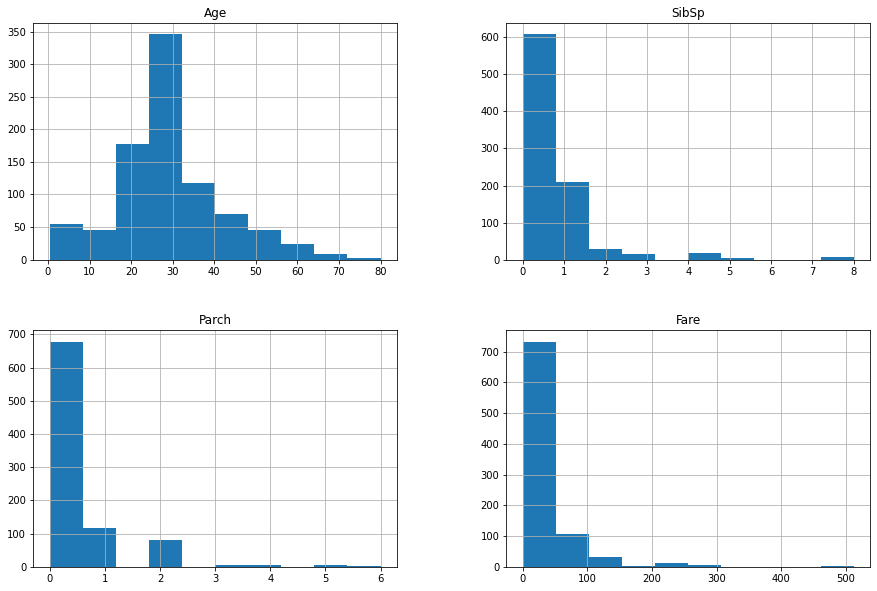

In [7]:
# Numeric Feature EDA
numeric_feature = train[['Age', 'SibSp', 'Parch', 'Fare']]
numeric_feature.hist(figsize= (15, 10))

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

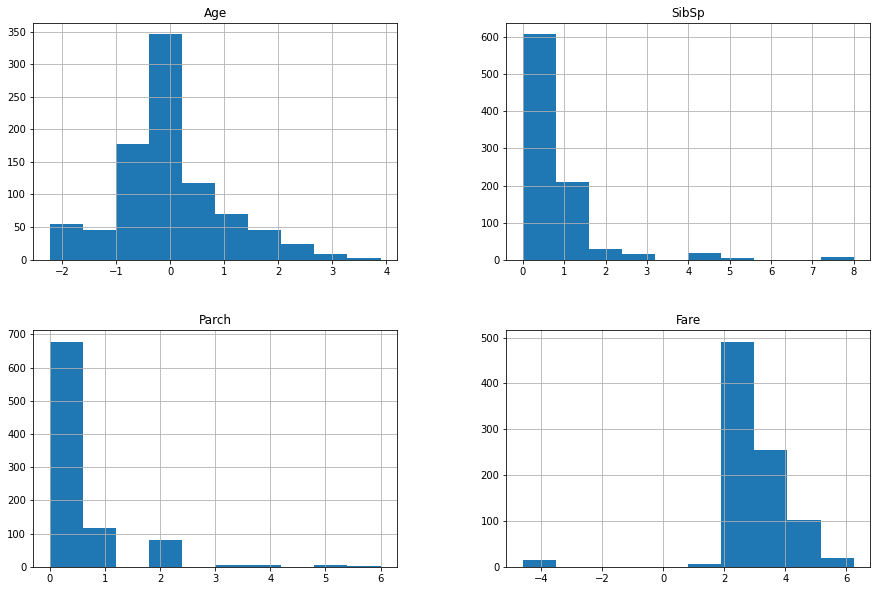

In [8]:
# Scaling 'Age' for the model
scaler = StandardScaler()
train['Age'] = scaler.fit_transform(train[['Age']])
test['Age'] = scaler.fit_transform(test[['Age']])  

# Removing skewness of the rest of the parameters
train['Fare'] = np.log(train['Fare'] + 0.01)
test['Fare'] = np.log(test['Fare'] + 0.01)

train[['Age', 'SibSp', 'Parch', 'Fare']].hist(figsize=(15,10))

In this case we see that both Parch and SibSp are quite difficult to scale and remove skewness due to this information and knowing that this values are `SibSp` Number of Siblings/Spouses aboard and `Parch` Number of Parents/Children which might create some correlation between the values we create a categorical feature to see if they boarded alone or not.

In [9]:
# Train Feature 
train['Alone'] = train['SibSp'] + train['Parch']

for index in range(len(train)):
    if train['Alone'][index] != 0:
        train['Alone'][index] = 0
    else:
        train['Alone'][index] = 1

# Test Feature
test['Alone'] = test['SibSp'] + test['Parch']

for index in range(len(test)):
    if test['Alone'][index] != 0:
        test['Alone'][index] = 0
    else:
        test['Alone'][index] = 1

C:\Users\ruben\AppData\Local\Temp\ipykernel_9680\1130602062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Alone'][index] = 0
C:\Users\ruben\AppData\Local\Temp\ipykernel_9680\1130602062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Alone'][index] = 1
C:\Users\ruben\AppData\Local\Temp\ipykernel_9680\1130602062.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Alone'][index] = 1
C:\Users\ruben\AppData\Lo

Now that I've finished with the numeric clean up I'll focus on the categorical data manipulation in order to be passed into multiple models.

In [10]:
# Categoric Feature EDA
print('Values to impute:',train['Embarked'].isna().sum())
print(train['Embarked'].value_counts())

Values to impute: 2
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [11]:
train['Embarked'].fillna('S', inplace=True)

After I've dealt with the missing values I'll use the Sklearn `OneHotEncoder` tool to transform my categories into multiple columns which will used by certain models to interpret the feature

In [12]:
oneHot = OneHotEncoder(categories='auto', handle_unknown='ignore')
feature_array = oneHot.fit_transform(train[['Pclass', 'Sex', 'Embarked']]).toarray()

feature_labels = oneHot.categories_
feature_labels = list(np.concatenate(feature_labels).flat)
feature_labels[0] = 'C1'
feature_labels[1] = 'C2'
feature_labels[2] = 'C3'

encoded_features = pd.DataFrame(feature_array, columns=feature_labels)

interestdf = train.merge(encoded_features, left_index=True, right_index=True)

features = ['C1', 'C2', 'C3', 'female', 'male', 'C', 'Q', 'S', 'Age', 'Fare', 'Alone']
X = interestdf[features]
y = interestdf['Survived']

In [13]:
feature_array = oneHot.fit_transform(test[['Pclass', 'Sex', 'Embarked']]).toarray()

feature_labels = oneHot.categories_
feature_labels = list(np.concatenate(feature_labels).flat)
feature_labels[0] = 'C1'
feature_labels[1] = 'C2'
feature_labels[2] = 'C3'

encoded_features = pd.DataFrame(feature_array, columns=feature_labels)

interestdf = test.merge(encoded_features, left_index=True, right_index=True)

features = ['C1', 'C2', 'C3', 'female', 'male', 'C', 'Q', 'S', 'Age', 'Fare', 'Alone']
X_test = interestdf[features]
y_test = interestdf['Survived']

After I've finished I'll create a pairplot, just to visually discard any kind of colinearity between some of the features.

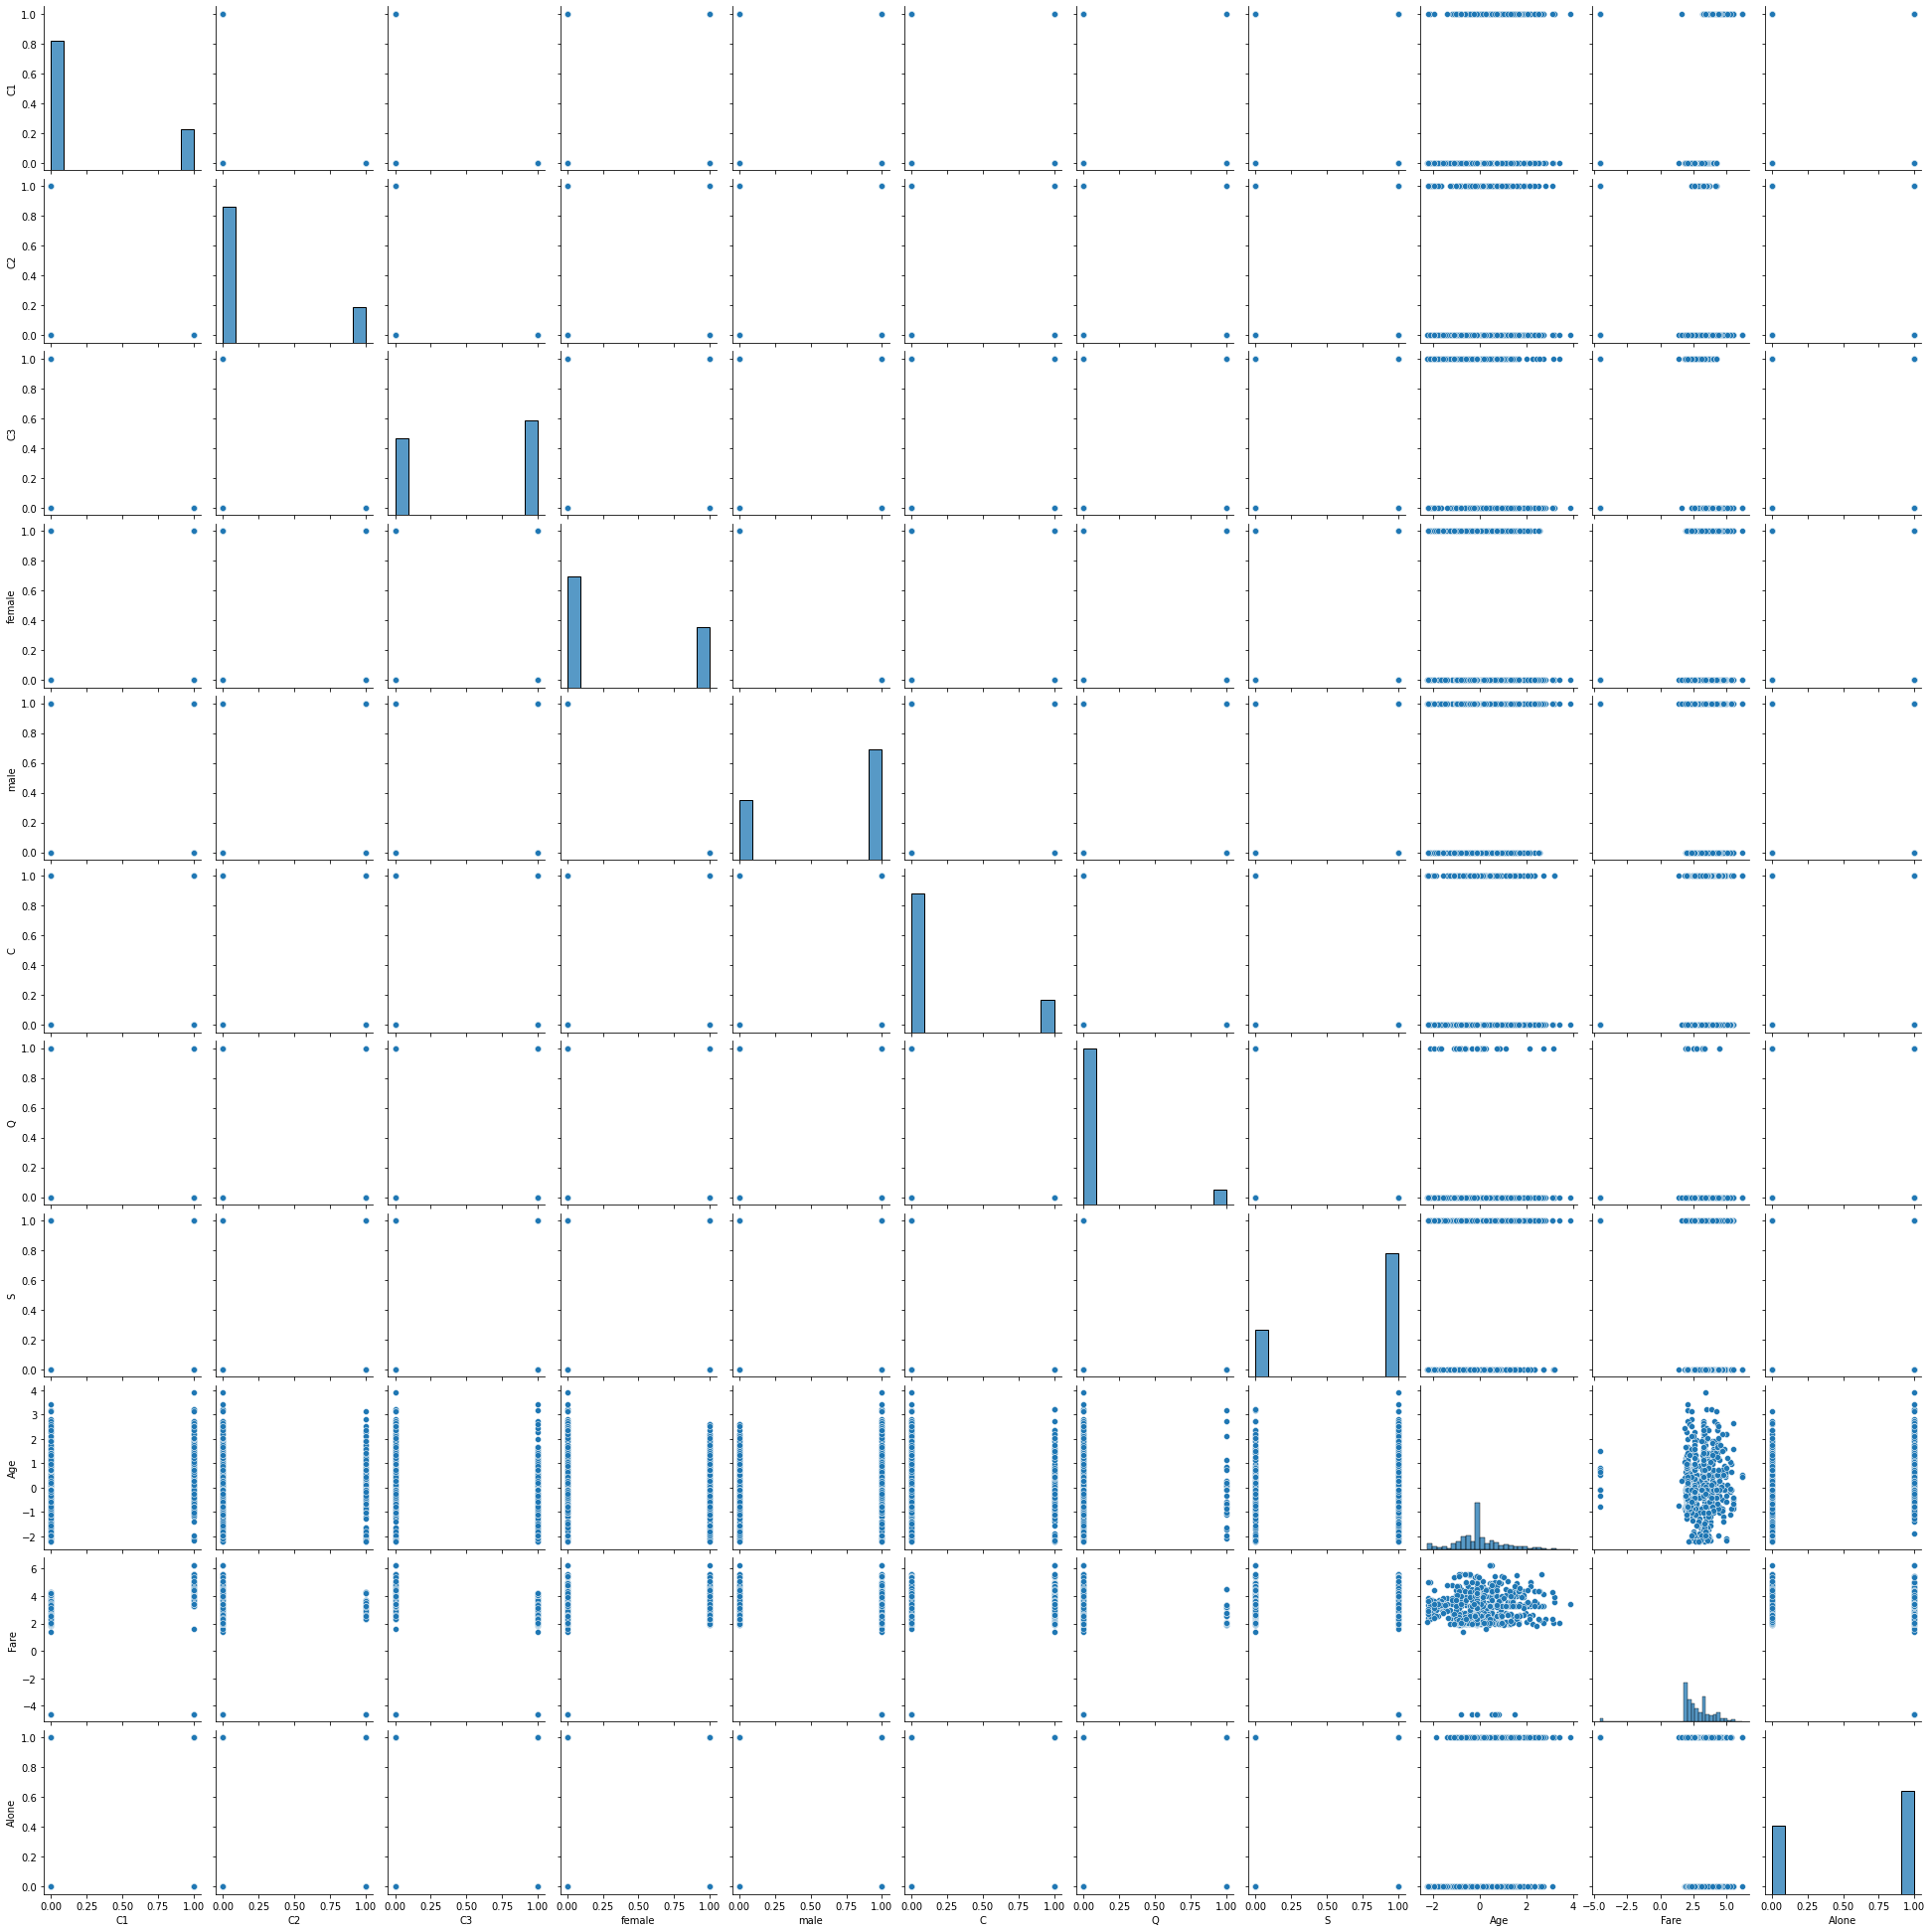

In [14]:
sns.pairplot(X)

#### Model Testing

At this point we have done all the feature preprocessing we need to pass through our models and see how they perform in this competiton.
The models that I'll using in this case are the following:
* Logistic Regression
* Decision Tree
* Random Forest
* AdaBoost Classifier
* Support Vector Classifier

I'll print the confusion matrix and accuracy of both the train and test data sets just to see how each of the models perform. For Random Forest, AdaBoost & SVC I'll try to do a gridsearch to find some hyperparameters and compare their performance too.

#### Logistic Regression

In [15]:
LR_mod = LogisticRegression().fit(X,y)
LR_y_pred = LR_mod.predict(X)

print('Train LR Confusion Matrix\n',pd.DataFrame(confusion_matrix(y,LR_y_pred, labels=[0,1])))
print('Train Accuracy', accuracy_score(y,LR_y_pred))

test_LR_y_pred = LR_mod.predict(X_test)
print('Test LR Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,test_LR_y_pred, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,test_LR_y_pred))

print(pd.DataFrame(LR_mod.coef_, columns=LR_mod.feature_names_in_))


Train LR Confusion Matrix
      0    1
0  465   84
1  100  242
Train Accuracy 0.7934904601571269
Test LR Confusion Matrix
      0    1
0  253   13
1    8  144
Test Accuracy 0.9497607655502392
         C1       C2        C3    female     male        C         Q  \
0  0.954611  0.15191 -1.106478  1.258292 -1.25825  0.17816  0.154888   

          S       Age      Fare     Alone  
0 -0.333007 -0.416391  0.117811  0.150993  


#### Decision Tree

In [16]:
DT_mod = DecisionTreeClassifier().fit(X,y)
DT_y_pred = DT_mod.predict(X)

print('Train DT Confusion Matrix\n',pd.DataFrame(confusion_matrix(y,DT_y_pred, labels=[0,1])))
print('Train Accuracy', accuracy_score(y,DT_y_pred))

test_DT_y_pred = DT_mod.predict(X_test)
print('Test LR Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,test_DT_y_pred, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,test_DT_y_pred))

labels = DT_mod.feature_names_in_
coefs = np.reshape(DT_mod.feature_importances_,(1,11))

print(pd.DataFrame(coefs, columns=labels))

Train DT Confusion Matrix
      0    1
0  547    2
1   16  326
Train Accuracy 0.9797979797979798
Test LR Confusion Matrix
      0    1
0  201   65
1   36  116
Test Accuracy 0.7583732057416268
         C1        C2        C3    female  male         C         Q         S  \
0  0.027693  0.004634  0.090933  0.310881   0.0  0.006724  0.003009  0.014533   

        Age      Fare     Alone  
0  0.248311  0.276476  0.016807  


#### Random Forest

In [17]:
RF_mod = RandomForestClassifier().fit(X,y)
RF_y_pred = RF_mod.predict(X)

print('Train RF Confusion Matrix\n',pd.DataFrame(confusion_matrix(y,RF_y_pred, labels=[0,1])))
print('Train Accuracy', accuracy_score(y,RF_y_pred))

test_RF_y_pred = RF_mod.predict(X_test)
print('Test RF Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,test_RF_y_pred, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,test_RF_y_pred))

labels = RF_mod.feature_names_in_
coefs = np.reshape(RF_mod.feature_importances_,(1,11))

print(pd.DataFrame(coefs, columns=labels))

# GridSearch Random Forest

parameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 3],
    'min_samples_split': [2, 5, 10],
    'max_leaf_nodes': [None, 10, 20]
    }

GS = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
GS.fit(X,y)

print(GS.best_params_, GS.best_estimator_, GS.best_score_)
best = GS.best_estimator_.predict(X_test)
print('Test best RF Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,best, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,best))

Train RF Confusion Matrix
      0    1
0  545    4
1   14  328
Train Accuracy 0.9797979797979798
Test RF Confusion Matrix
      0    1
0  227   39
1   35  117
Test Accuracy 0.8229665071770335
        C1        C2       C3    female      male         C         Q  \
0  0.03415  0.018217  0.05276  0.131045  0.154221  0.011131  0.006742   

          S       Age      Fare     Alone  
0  0.013526  0.277553  0.280733  0.019923  
{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 5, 'n_estimators': 200} RandomForestClassifier(min_samples_split=5, n_estimators=200) 0.8204632477559475
Test best RF Confusion Matrix
      0    1
0  241   25
1   33  119
Test Accuracy 0.861244019138756


#### AdaBoost Classifier

In [18]:
AB_mod = AdaBoostClassifier().fit(X,y)
AB_y_pred = AB_mod.predict(X)

print('Train AB Confusion Matrix\n',pd.DataFrame(confusion_matrix(y,AB_y_pred, labels=[0,1])))
print('Train Accuracy', accuracy_score(y,AB_y_pred))

test_AB_y_pred = AB_mod.predict(X_test)
print('Test AB Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,test_AB_y_pred, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,test_AB_y_pred))

labels = AB_mod.feature_names_in_
coefs = np.reshape(AB_mod.feature_importances_,(1,11))

print(pd.DataFrame(coefs, columns=labels))

# GridSearch AdaBoost

parameters = {
    'learning_rate': [0.5, 1, 1.25, 1.5, 1.75, 2],
    }

GS = GridSearchCV(AdaBoostClassifier(), parameters, cv=5)
GS.fit(X,y)

print(GS.best_params_, GS.best_estimator_, GS.best_score_)
best = GS.best_estimator_.predict(X_test)
print('Test best AB Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,best, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,best))

Train AB Confusion Matrix
      0    1
0  483   66
1   78  264
Train Accuracy 0.8383838383838383
Test AB Confusion Matrix
      0    1
0  235   31
1   14  138
Test Accuracy 0.8923444976076556
     C1    C2    C3  female  male    C    Q     S  Age  Fare  Alone
0  0.04  0.02  0.04     0.0  0.04  0.0  0.0  0.02  0.3  0.52   0.02
{'learning_rate': 1.25} AdaBoostClassifier(learning_rate=1.25) 0.8103571652752495
Test best AB Confusion Matrix
      0    1
0  234   32
1   14  138
Test Accuracy 0.8899521531100478


#### Support Vector Classifier

In [19]:
SV_mod = SVC().fit(X,y)
SV_y_pred = SV_mod.predict(X)

print('Train SV Confusion Matrix\n',pd.DataFrame(confusion_matrix(y,SV_y_pred, labels=[0,1])))
print('Train Accuracy', accuracy_score(y,SV_y_pred))

test_SV_y_pred = SV_mod.predict(X_test)
print('Test SV Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,test_SV_y_pred, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,test_SV_y_pred))

# GridSearch Suport Vector Classifier

parameters = {
    'C': [0.25, 1, 10],
    'kernel': ['poly', 'rbf']
    }

GS = GridSearchCV(SVC(), parameters, cv=3)
GS.fit(X,y)

print(GS.best_params_, GS.best_estimator_, GS.best_score_)
best = GS.best_estimator_.predict(X_test)
print('Test best SV Confusion Matrix\n',pd.DataFrame(confusion_matrix(y_test,best, labels=[0,1])))
print('Test Accuracy', accuracy_score(y_test,best))

Train SV Confusion Matrix
      0    1
0  506   43
1  116  226
Train Accuracy 0.8215488215488216
Test SV Confusion Matrix
      0    1
0  265    1
1   23  129
Test Accuracy 0.9425837320574163
{'C': 10, 'kernel': 'rbf'} SVC(C=10) 0.8103254769921436
Test best SV Confusion Matrix
      0    1
0  257    9
1   39  113
Test Accuracy 0.8851674641148325


## Summary

All of the models below perform in this table.
|       Model      |Train Accuracy              |Test Accuracy       |Notes|
|------------------|----------------------------|--------------------|-----|
|Linear Regression |0.7934                      |0.9498              |The top features were `1st class` and  `women` features.|
|Decision Tree     |0.9798                      |0.7584              |The top features were `women` in first place and `fare` & `age` features second.|
|Random Forest     |0.9798 / Grid 0.8205        |0.8230 / Grid 0.8612|`fare` & `age` features are the key features.|
|AdaBoost          |0.8384 / Grid 0.8104        |0.8923 / Grid 0.8900|`fare` & `age` features are the key features with `fare` being almost twice the important feature.|
|SVC               |0.8215 / Grid 0.8103        |0.9425 / Grid 0.8851| The model shows a better performance with default values on test data.|

Thank you for taking the time to review my project and please feel free to reach out if you have any question or feedback.